# Titanic - Machine Learning from Disaster
Overview From kaggle:  
The data has been split into two groups:

1. training set (train.csv)
2. test set (test.csv)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.  

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.  

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.  

| Variable | Definition                                  | Key                                            |
| -------- | ------------------------------------------- | ---------------------------------------------- |
| Survived | Survival                                    | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                                | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                         |                                                |
| Age      | Age in years                                |                                                |
| Sibsp    | \# of siblings / spouses aboard the Titanic |                                                |
| Parch    | \# of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                               |                                                |
| Fare     | Passenger fare                              |                                                |
| Cabin    | Cabin number                                |                                                |
| Embarked | Port of Embarkation                         | C = Cherbourg, Q = Queenstown, S = Southampton |

Variable Notes
pclass: A proxy for socio-economic status (SES)  
1st = Upper  
2nd = Middle  
3rd = Lower  

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5  

sibsp: The dataset defines family relations in this way...  
Sibling = brother, sister, stepbrother, stepsister  
Spouse = husband, wife (mistresses and fiancés were ignored)  

parch: The dataset defines family relations in this way...  
Parent = mother, father  
Child = daughter, son, stepdaughter, stepson  
Some children travelled only with a nanny, therefore parch=0 for them.

In [2]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

data = pd.read_csv('./train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploration

Mapping

In [3]:
#Survived_map = {0:'No', 1:'Yes'}
Pclass_map = {1:'First Class', 2:'Second Class', 3:'Third Class'}
Embarked_map = {'C':'Cherbourg', 'Q':'Queenstown', 'S':'Southampton'}

#data.survived = data.Survived.map(Survived_map)
data.Pclass = data.Pclass.map(Pclass_map)
data.Embarked = data.Embarked.map(Embarked_map)

Visualization

In [4]:
data.describe()

,PassengerId,Survived,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,80.000000,8.000000,6.000000,512.329200


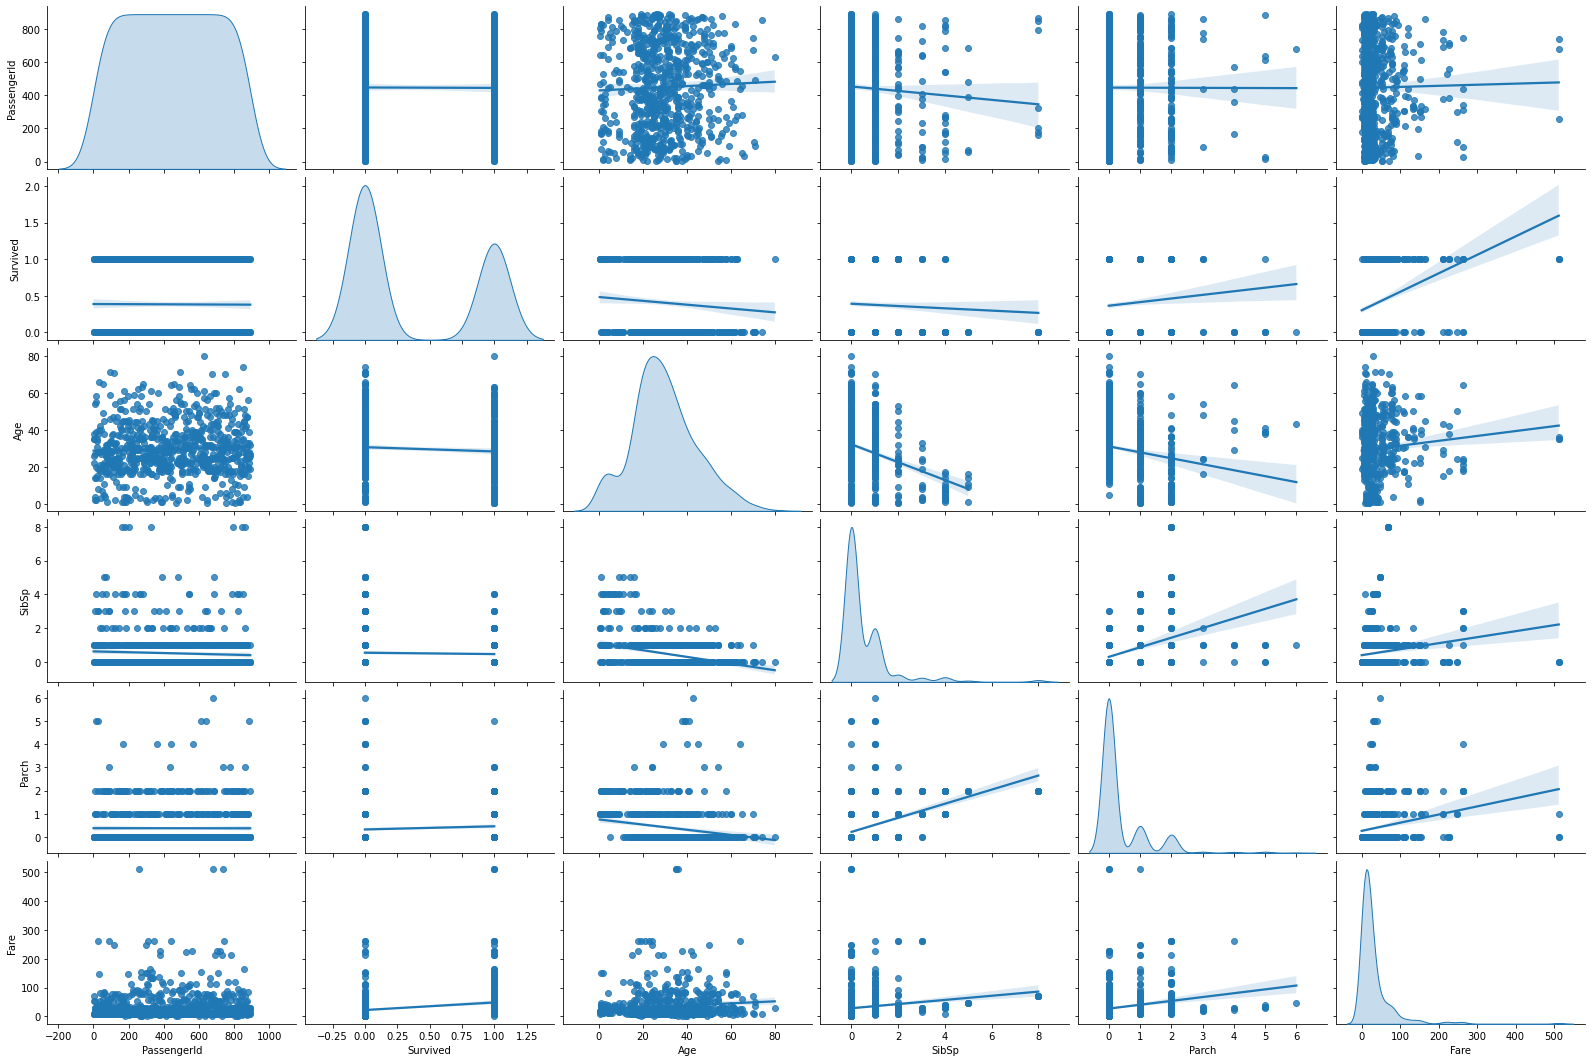

In [7]:
sns.pairplot(data=data, diag_kind='kde', kind='reg', aspect=1.5)

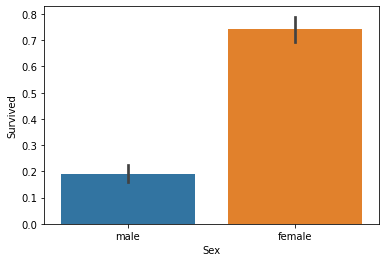

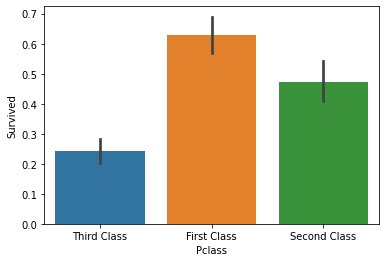

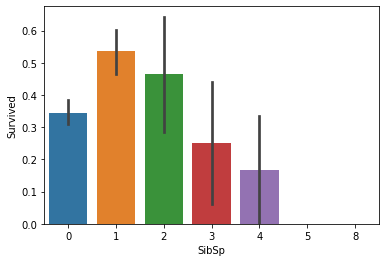

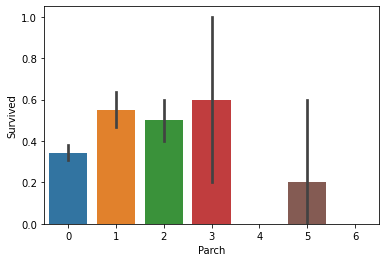

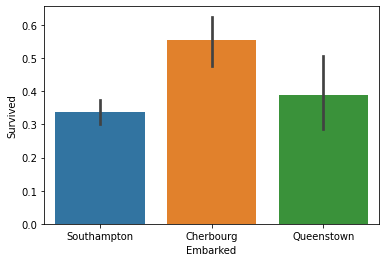

In [6]:
barplot_x = ('Sex', 'Pclass', 'SibSp', 'Parch', 'Embarked')
for x in barplot_x:
    plt.figure()
    sns.barplot(x=x, y='Survived', data = data)

### Formatting the data
I will be using a subset of the training data to test before finilizing the model. The original testing dataset will be called submit. The finilized model will use the full training set.

In [2]:
train_full = pd.read_csv('./train.csv')
submit = pd.read_csv('./test.csv')

submit['submit'] = True
submit['Survived'] = -1
train_full['submit'] = False
data = pd.concat([submit, train_full], copy=True)
del submit, train_full

data['Survived'] = data['Survived'].astype(int)
data['Embarked'] = data['Embarked'].map({'S':0, 'C':1, 'Q':2})
data['Sex'] = data['Sex'].map( {'male':1, 'female':0} )

data.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked       float64
submit            bool
Survived         int32
dtype: object

### PreProcessing

In [3]:
data.isnull().sum(axis=0)

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
submit            0
Survived          0
dtype: int64

I will set the single NA fare to the average Fare and the 2 NA embarked values to the most common location Southhampton or 0.

In [4]:
data['Fare'].fillna(np.average(data[data['Fare'].notnull()]['Fare']), inplace=True)
data['Embarked'].fillna(0, inplace=True)

Many of the Age values are missing. I will use a linear model to predict age for each of the missing values. Like the original dataset, predicted ages will be of the format XX.5.

In [5]:
import sklearn.linear_model as lm

age_train_x = data.drop(['Name', 'Ticket', 'Cabin', 'submit'], axis=1).dropna().drop('Age', axis=1)
age_train_y = data['Age'].dropna()

age_mod = lm.LinearRegression()
age_mod.fit(age_train_x, age_train_y)

age_na = data[data['Age'].isna()].copy()
age_na_x = age_na.drop(['Name', 'Ticket', 'Cabin', 'submit', 'Age'], axis=1)

# round and make end in 0.5
age_na['Age'] = np.subtract(np.add(age_mod.predict(age_na_x),0.5).round(),0.5)
age_na[age_na['Age'] < 0]['Age'] = 0.5
data[data['Age'].isna()] = age_na

C:\Users\AlexC\AppData\Local\Temp/ipykernel_20444/2659378788.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_na[age_na['Age'] < 0]['Age'] = 0.5


In [6]:
data.isnull().sum(axis=0)

PassengerId       0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
submit            0
Survived          0
dtype: int64

#### Adding Some More Variables

In [7]:
data['Prefix'] = data['Name'].apply(lambda s: s.split(', ')[1].split('. ')[0]).map(
    {'Mr':0,
    'Miss':1,
    'Mrs':2,
    'Master':3,
    'Rev':4,
    'Dr':5,
    'Col':6,
    'Ms':7,
    'Major':8,
    'Mlle':9,
    'Sir':9,
    'the Countess':9,
    'Capt':9,
    'Don':9,
    'Lady':9,
    'Mme':9,
    'Dona':9,
    'Jonkheer':9})
data['Prefix'].dtype

dtype('int64')

#### Subsetting The Data

In [8]:
from sklearn.model_selection import train_test_split
train_full = data[data['submit'] == False].drop('submit', axis=1)
train, test = train_test_split(train_full)
submit = data[data['submit'] == True].drop(['submit'], axis=1)

In [9]:
x_var_remove = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived']

train_x = train.drop(x_var_remove, axis=1)
train_y = train['Survived']

train_full_x = train_full.drop(x_var_remove, axis=1)
train_full_y = train_full['Survived']

submit_x = submit.drop(x_var_remove, axis=1)
predictions = submit[['PassengerId', 'Survived']].copy()

test_x = test.drop(x_var_remove, axis=1)
test_y = test['Survived']

## Modeling  


### Linear SVM

In [10]:
from sklearn import svm
from sklearn.metrics import classification_report

mod_svc = svm.SVC()
mod_svc.fit(train_x, train_y)

print(classification_report(test_y, mod_svc.predict(test_x)))

              precision    recall  f1-score   support

           0       0.69      0.93      0.79       139
           1       0.73      0.32      0.45        84

    accuracy                           0.70       223
   macro avg       0.71      0.62      0.62       223
weighted avg       0.71      0.70      0.66       223



### Logistic Regression

In [11]:
mod_log = lm.LogisticRegression(max_iter=1000)
mod_log.fit(train_x, train_y)

print(classification_report(test_y, mod_log.predict(test_x)))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       139
           1       0.77      0.67      0.71        84

    accuracy                           0.80       223
   macro avg       0.79      0.77      0.78       223
weighted avg       0.80      0.80      0.79       223



### Passive Agressive

In [12]:
mod_pag = lm.PassiveAggressiveClassifier()
mod_pag.fit(train_x, train_y)

print(classification_report(test_y, mod_pag.predict(test_x)))

              precision    recall  f1-score   support

           0       0.84      0.67      0.74       139
           1       0.59      0.79      0.67        84

    accuracy                           0.71       223
   macro avg       0.71      0.73      0.71       223
weighted avg       0.74      0.71      0.72       223



### Decision Tree

In [13]:
from sklearn import tree

mod_dec = tree.DecisionTreeClassifier()
mod_dec.fit(train_x, train_y)

print(classification_report(test_y, mod_dec.predict(test_x)))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       139
           1       0.79      0.73      0.76        84

    accuracy                           0.83       223
   macro avg       0.82      0.81      0.81       223
weighted avg       0.82      0.83      0.82       223



### Naive Bayes

In [14]:
from sklearn import naive_bayes

mod_gnb = naive_bayes.GaussianNB()
mod_gnb.fit(train_x, train_y)

print(classification_report(test_y, mod_gnb.predict(test_x)))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82       139
           1       0.70      0.67      0.68        84

    accuracy                           0.77       223
   macro avg       0.75      0.75      0.75       223
weighted avg       0.76      0.77      0.77       223



### Random Forest

In [15]:
from sklearn import ensemble

mod_rfo = ensemble.RandomForestClassifier(n_estimators=1000)
mod_rfo.fit(train_x, train_y)

print(classification_report(test_y, mod_rfo.predict(test_x)))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       139
           1       0.78      0.73      0.75        84

    accuracy                           0.82       223
   macro avg       0.81      0.80      0.81       223
weighted avg       0.82      0.82      0.82       223



### Gradient Boosting

In [16]:
mod_gbc = ensemble.GradientBoostingClassifier(n_estimators=500)
mod_gbc.fit(train_x, train_y)
print(classification_report(test_y, mod_gbc.predict(test_x)))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88       139
           1       0.81      0.76      0.79        84

    accuracy                           0.84       223
   macro avg       0.84      0.83      0.83       223
weighted avg       0.84      0.84      0.84       223



### Ada Boost

In [17]:
mod_ada = ensemble.AdaBoostClassifier(n_estimators=50)
mod_ada.fit(train_x, train_y)
print(classification_report(test_y, mod_ada.predict(test_x)))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       139
           1       0.78      0.74      0.76        84

    accuracy                           0.82       223
   macro avg       0.81      0.80      0.81       223
weighted avg       0.82      0.82      0.82       223



### Tuning Best Model  
Which appears to be gradient boosting

In [18]:
from sklearn import model_selection as ms

parameters = {
    "learning_rate": [0.01, 0.025, 0.05],
    "n_estimators":list(range(400,625,25))
    }


gbc = ensemble.GradientBoostingClassifier()
gscv_gbc = ms.GridSearchCV(gbc, parameters, cv=5, n_jobs=-1, verbose=4)

In [19]:
gscv_gbc.fit(train_x, train_y)
print(classification_report(test_y, gscv_gbc.predict(test_x)))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       139
           1       0.84      0.77      0.81        84

    accuracy                           0.86       223
   macro avg       0.86      0.84      0.85       223
weighted avg       0.86      0.86      0.86       223



In [20]:
results = pd.DataFrame.from_dict(gscv_gbc.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.373198,0.006430,0.003000,9.221592e-07,0.01,400,"{'learning_rate': 0.01, 'n_estimators': 400}",0.820896,0.828358,0.835821,0.789474,0.796992,0.814308,0.018001,23
1,0.443201,0.030759,0.003199,3.995665e-04,0.01,425,"{'learning_rate': 0.01, 'n_estimators': 425}",0.813433,0.828358,0.835821,0.789474,0.796992,0.812816,0.017700,25
2,0.416399,0.012986,0.003000,1.177701e-06,0.01,450,"{'learning_rate': 0.01, 'n_estimators': 450}",0.820896,0.828358,0.835821,0.789474,0.796992,0.814308,0.018001,23
3,0.445799,0.037376,0.003201,3.997332e-04,0.01,475,"{'learning_rate': 0.01, 'n_estimators': 475}",0.820896,0.828358,0.835821,0.796992,0.796992,0.815812,0.016075,18
4,0.481999,0.025753,0.003000,1.237941e-06,0.01,500,"{'learning_rate': 0.01, 'n_estimators': 500}",0.820896,0.828358,0.835821,0.796992,0.796992,0.815812,0.016075,18
5,0.484399,0.031771,0.003200,4.002591e-04,0.01,525,"{'learning_rate': 0.01, 'n_estimators': 525}",0.820896,0.828358,0.835821,0.796992,0.796992,0.815812,0.016075,18
6,0.550799,0.028819,0.003401,4.912070e-04,0.01,550,"{'learning_rate': 0.01, 'n_estimators': 550}",0.820896,0.835821,0.820896,0.796992,0.796992,0.814319,0.015161,22
7,0.535399,0.056588,0.003800,7.478825e-04,0.01,575,"{'learning_rate': 0.01, 'n_estimators': 575}",0.820896,0.835821,0.820896,0.804511,0.796992,0.815823,0.013667,16
8,0.620400,0.095087,0.003799,7.477563e-04,0.01,600,"{'learning_rate': 0.01, 'n_estimators': 600}",0.820896,0.835821,0.820896,0.804511,0.796992,0.815823,0.013667,16
9,0.414800,0.063854,0.002800,3.988037e-04,0.025,400,"{'learning_rate': 0.025, 'n_estimators': 400}",0.828358,0.880597,0.828358,0.789474,0.796992,0.824756,0.032124,9


In [21]:
gscv_gbc = ms.GridSearchCV(gbc, parameters, n_jobs=-1, verbose=4)
gscv_gbc.fit(train_full_x, train_full_y)
predictions['Survived'] = gscv_gbc.predict(submit_x)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


### Outputting Final Predictions

In [24]:
predictions.to_csv('./final_submission.csv', index=False)
predictions

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
